In [45]:
%reload_ext autoreload
%autoreload 2
import os
import glob
import scipy.io.wavfile as wv
import matplotlib.pyplot as plt
import numpy as np
from util import util
import scipy.signal as sig
from keras.models import Sequential
from keras.layers import Dense
from util.confusionMatrix import ConfusionMatrix

In [2]:
classes = ['music', 'voice', 'environment']

macDir = '/Volumes/SAA_DATA/datasets/'
winDir = 'E:/SAA_DATA/'
osDir = winDir

baseTargetDir = '/Users/etto/Desktop/pData'
baseTargetDir = 'E:/SAA_DATA/targetDir'

baseSrcDir = osDir + 'localizationFiles/20171025AllExtractionsMic4'
orgWavDirs1 = ['G428_0.0_1.4',
              'G527_0.5_1.4',
              'Studio_2.0_4.2'
              ]

orgWavDirs2 = ['G428_2.1_2.4',
              'G527_1.2_5.8',
              'Studio_3.0_2.0'
              ]

NFFT = 1024

storageFolder = '../storedData/'

In [3]:
# Train alleen op 1 van de org dirs
srcDir = baseSrcDir + '/' + orgWavDirs1[0]
filesPerCategory = {}
for catDirLong in glob.glob(srcDir + '/*'):
    catDir = catDirLong.replace('\\', '/')
    catDir = catDir.replace(srcDir + '/', '')
    
    filesPerCategory[catDir] = []
    for filename in glob.glob(catDirLong + '/*'):
        filename = filename.replace('\\','/')
        filesPerCategory[catDir].append(filename)


In [4]:
# maak spectros van elke file
spectros = {}
for clz in classes:
    spectros[clz] = []
    for filename in filesPerCategory[clz]:
        fs, signal = wv.read(filename)
        freq_array, segment_times, spectrogram = sig.spectrogram(x=signal, fs=fs, nfft=NFFT, noverlap=0)
        spectros[clz].append(spectrogram.T)
        

In [5]:
#alle X achter elkaar in goede volgorde

X_train = np.concatenate(spectros[classes[0]], axis=0)
for i in range(1, len(classes)):
    nwSpectros = np.concatenate(spectros[classes[i]], axis=0)
    X_train = np.concatenate((X_train,nwSpectros), axis=0) 

np.shape(X_train)

(187316, 513)

In [6]:
clzLengths = {}
for clz in classes:
    clzLengths[clz] = sum([np.shape(lst)[0] for lst in spectros[clz]])
print(clzLengths)

{'music': 60205, 'voice': 60859, 'environment': 66252}


In [7]:
# one-hot encoding
clsNr = 0
nrFiles = clzLengths[classes[0]]
Y_train = np.array((np.ones(nrFiles),np.zeros(nrFiles), np.zeros(nrFiles))).T

nrFiles = clzLengths[classes[1]]
Y_train_nw = np.array((np.zeros(nrFiles),np.ones(nrFiles), np.zeros(nrFiles))).T
Y_train = np.concatenate((Y_train, Y_train_nw),axis=0)

nrFiles = clzLengths[classes[2]]
Y_train_nw = np.array((np.zeros(nrFiles),np.zeros(nrFiles), np.ones(nrFiles))).T
Y_train = np.concatenate((Y_train, Y_train_nw),axis=0)
print(np.shape(Y_train))

(187316, 3)


zie https://machinelearningmastery.com/multi-class-classification-tutorial-keras-deep-learning-library/

In [8]:
# define baseline model
def create_model():
    # create model
    model = Sequential()
    model.add(Dense(100, input_dim=513, activation='relu'))
    model.add(Dense(20, activation='relu'))
    model.add(Dense(3, activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model


In [9]:
soundModel = create_model()
history = soundModel.fit(X_train, Y_train, epochs=5, shuffle=True, verbose=1)

Epoch 1/5
187316/187316 [==============================] - 31s 166us/step - loss: 0.2111 - acc: 0.9225
Epoch 2/5
187316/187316 [==============================] - 27s 144us/step - loss: 0.1248 - acc: 0.9540
Epoch 3/5
187316/187316 [==============================] - 27s 143us/step - loss: 0.1041 - acc: 0.96121s - loss: 
Epoch 4/5
187316/187316 [==============================] - 26s 138us/step - loss: 0.0912 - acc: 0.96571
Epoch 5/5
187316/187316 [==============================] - 26s 137us/step - loss: 0.0831 - acc: 0.9684


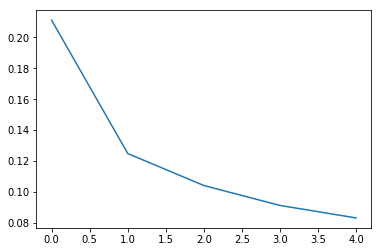

In [10]:
plt.plot(history.history['loss'])
plt.show()

In [11]:
soundModel.save(storageFolder + 'prf20180714.hd5')

## evalueer op traindata

In [72]:
# predicted classes
predictions = soundModel.predict(X_train)
predClasses = predictions.argmax(axis=1)

# real classes
realClasses = np.concatenate((np.zeros(clzLengths[classes[0]]), 
                              np.ones(clzLengths[classes[1]]), 
                              2*np.ones(clzLengths[classes[2]])))

matrix = ConfusionMatrix(classes)
for vals in zip(realClasses, predClasses):
    matrix.add(int(vals[0]), int(vals[1]), 1)
print(matrix.toString())
print()
print(matrix.toF1String())

                   m       v       e |  sens   acc
music          57105    3004      96 |  0.95  0.98
voice            544   59228    1087 |  0.97  0.97
environment       36     958   65258 |  0.98  0.99
--------------------------------------
prec            0.99    0.94    0.98

F1 overall: 0.97
F1 music: 0.97
F1 voice: 0.95
F1 environment: 0.98



## Testen op soundchunks

In [99]:
import importlib
from util import WavFileParts
import wave

def readSoundChunksDynamic(moduleString):
    chunks = importlib.import_module(moduleString).soundChunks
    wfPts = []
    for jsonString in chunks:
        wfPts.append(WavFileParts.WavFilePartFromJson(jsonString))
    return wfPts

In [82]:
chunksBaseDir = 'chunks'
rooms = ['Studio', 'G428', 'G527']

In [84]:
wfPts = readSoundChunksDynamic(chunksBaseDir + '.' + 'Studio' + '.soundChunks')

In [89]:
wf = wfPts[0]

In [90]:
wf.fileNr

740

In [92]:
wf.getSoundType()

'Gunshot'

In [101]:
datasetDir = osDir + 'localizationRecordings/20171011'
fileDate = 170816
micNr = 4
filename = datasetDir + '/{:d}_{:d}_mono{:d}.wav'.format(fileDate, wf.fileNr, micNr)
filename

'E:/SAA_DATA/localizationRecordings/20171011/170816_740_mono4.wav'

In [102]:
sc = wf.getSoundChunks(micNr)[0]

In [103]:
sc

[8.030385487528346, 8.29453514739229]

In [116]:
wf.getSoundType()

'Gunshot'

In [133]:
sourceFile = wave.open(filename, 'rb')
frameRate = sourceFile.getframerate()
nChannels = sourceFile.getnchannels()
sampWidth = sourceFile.getsampwidth()

targetName = '../storedData/dumpFolder/extracted.wav'

for soundChunk in [sc]: #fpt.getSoundChunks(micNr):
    # extract file part
    targetFile = wave.open(targetName, 'wb')
    targetFile.setnchannels(nChannels)
    targetFile.setsampwidth(sampWidth)
    targetFile.setframerate(frameRate)

    startFrame = int(soundChunk[0] * frameRate)
    endFrame = int(soundChunk[1] * frameRate)

    sourceFile.setpos(startFrame)
    wavBytes = sourceFile.readframes((endFrame - startFrame))

    targetFile.writeframes(wavBytes)
    targetFile.close()

In [134]:
# create spectros
fs, signal = wv.read(targetName)
freq_array, segment_times, spectrogram = sig.spectrogram(x=signal, fs=fs, nfft=NFFT, noverlap=0)

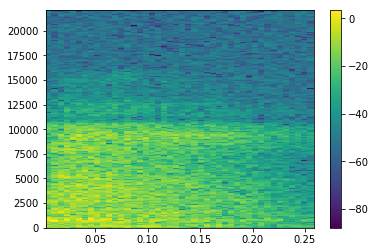

In [135]:
plt.pcolormesh(segment_times,freq_array,10 * np.log10(spectrogram))
plt.colorbar()

In [136]:
# nu zonder eerst naar file te schrijven

In [138]:
soundChunk = sc
fs, signal = wv.read(filename)
startFrame = int(soundChunk[0] * frameRate)
endFrame = int(soundChunk[1] * frameRate)

sigChunk = signal[startFrame: endFrame]
freq_array, segment_times, spectrogram2 = sig.spectrogram(x=sigChunk, fs=fs, nfft=NFFT, noverlap=0)

C:\Users\Etto\Anaconda2\envs\py36DL\lib\site-packages\scipy\io\wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


## en dan nu:
    bovenstaand fragment gebruiken:
        loop door wavfileparts
            als type != Gunshot
                bepaal classnr
                loop door soundchunks
                    bepaal spectrogram per soundchunk
                    plak spectrogram aan totale spectrogram
                    plak een stuk met lengte spectrogram aan Y waarden (true values)